<a href="https://colab.research.google.com/github/anniejwa/Classification_PoulationSize/blob/main/Copy_of_Classification_PopulationSize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Simulate effects of population size on decoding accuracy - after https://www.ncbi.nlm.nih.gov/pmc/articles/pmid/33582276/

accuracy rates for images defaced using pydeface:

- 16/157 (10%) without refacing
- 59/157 (38%) with reconstruction using mri_reface


In [ ]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score

!pip install faiss-cpu --no-cache
# NB: need to source setup.sh before running jupyter, to get MKL libs into path
import faiss



In [ ]:
# use faiss to run KNN: https://towardsdatascience.com/make-knn-300-times-faster-than-scikit-learns-in-20-lines-5e29d74e76bb

class FaissKNeighbors:
    def __init__(self, k=1):
        self.index = None
        self.y = None
        self.k = k

    def fit(self, X, y):
        self.index = faiss.IndexFlatL2(X.shape[1])
        self.index.add(X.astype(np.float32))
        self.y = y

    def predict(self, X):
        distances, indices = self.index.search(X.astype(np.float32), k=self.k)
        votes = self.y[indices]
        predictions = np.array([np.argmax(np.bincount(x)) for x in votes])
        return predictions

    def score(self, X, y):
        return(accuracy_score(y, self.predict(X)))

Rationale: We want to generate data for which a classifier (in this case a one-nearest-neighbor) will give a particular level of accuracy for the population size (157) used in the Schwarz et al. paper. Then we will use that same noise level to generate a larger population for which we will test classification accuracy.

In [ ]:
nfeatures = 100 # number of features used by classifier
npts = 157 # population size
noise_scale = 10 # amount of noise to be added

def nn_test(data, noise_scale, rng=None):
    """
    A function that takes a dataset, fits a nearest neighbor classifier,
    and then classifies observations generated by adding noise to the
    original data.

    inputs:
    data (ndarray): original data, population size X n features
    noise_scale (scalar): standard deviation of added noise
    rng: numpy random noise generator

    return:
    accuracy of resulting classification
    """

    if rng is None:
        rng = np.random.default_rng(None)
    target = np.arange(data.shape[0])
    nn = FaissKNeighbors()
    nn.fit(data, target)
    data_noised = data + rng.normal(scale=noise_scale, size=data.shape)
    return(nn.score(data_noised, target))

seed = 12345
rng = np.random.default_rng(seed)
data = rng.normal(scale=1, size=(npts,nfeatures))

nn_test(data, noise_scale, rng)

0.07643312101910828

We next need to determine, for a given level of accuracy, what the noise level is that would give that level of accuracy (on average).  
Initial testing suggested that the range of noise levels from 5-30 was sufficient to capture the range from maximum to minimum accuracy. We run a large number of simulations using noise values sampled randomly from that range, and then use a polynomial regression to estimate the relationship between noise level and accuracy.

In [ ]:
noise_range = [2.5, 20] #[5, 30]

results = []
for i in range(10000):
    noise_scale = rng.random() * np.diff(noise_range)[0] + noise_range[0]
    data = rng.normal(scale=1, size=(npts,nfeatures))
    results.append([noise_scale, nn_test(data, noise_scale, rng)])


In [ ]:
results_df = pd.DataFrame(results, columns=['noise_sd', 'accuracy'])

Text(0, 0.5, 'accuracy')

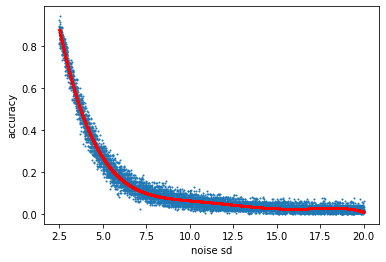

In [ ]:
# fit nonlinear function to results to get predicted accuracy and save to results_df
poly = PolynomialFeatures(5)
X = poly.fit_transform(results_df[['noise_sd']])
lr = LinearRegression(fit_intercept=False)
lr.fit(X, results_df.accuracy)
results_df['predicted'] = lr.predict(X)
plt.scatter(results_df.noise_sd, results_df.accuracy, s=1)
plt.scatter(results_df.noise_sd, results_df.predicted, color='red', s=1)
plt.xlabel('noise sd')
plt.ylabel('accuracy')

In [ ]:
# get noise level for target accuracy

def get_noise_level(target_accuracy, results_df):
    """
    A function to estimate the noise level needed to obtain
    a particular level of classification accuracy

    inputs:
    target_accuracy (float): desired accuracy
    results_df (DataFrame): data frame containing simulation results

    returns:
    noise level to give desired accuracy
    """
    absdiff = np.abs(results_df.predicted - target_accuracy)
    return(results_df.loc[np.argmin(absdiff),'noise_sd'])

get_noise_level(0.38, results_df)

4.276490518611774

This the main simulation, in which we vary population size to determine how classification accuracy decreases as a function of population size.  We first generate a dataset of individuals.  We then perform the analysis for the two levels of accuracy described above, varying across a range of population sizes from 157 (the population size in the Schwarz paper) up to 500,000. Random seeds were chosen manually for each accuracy level such that they give accuracy results for n=157 that are within 1% of the reported value.


In [ ]:
pop_sizes = [157, 250, 500, 1000, 5000, 10000, 100000, 500000]
popdata = rng.normal(size=(np.max(pop_sizes), nfeatures))
target_accuracy = [0.1, 0.38]



In [ ]:
# First, find the seeds that will get us into the correct range for each target accuracy level.


acc_seeds = {}
data_subset = popdata[:157, :]
for target_acc in target_accuracy:
    acc = -1
    target_noise = get_noise_level(target_acc, results_df)
    while (acc < target_acc) or (acc - target_acc > 0.01):
        seed = np.random.randint(10000000)
        rng = np.random.default_rng(seed)
        acc = nn_test(data_subset, target_noise, rng)
    acc_seeds[target_acc] = seed
    print(target_acc, acc, seed)



0.1 0.10828025477707007 9846476
0.38 0.3885350318471338 3228407


In [ ]:
sim_results = []

for target_accuracy in acc_seeds.keys():
    rng = np.random.default_rng(acc_seeds[target_accuracy])
    target_noise = get_noise_level(target_accuracy, results_df)
    for ps in pop_sizes:
        data_subset = popdata[:ps, :]
        result = nn_test(data_subset, target_noise, rng)
        sim_results.append([target_noise, ps, result])
        print([target_noise, ps, result])

[7.466803540935465, 157, 0.10828025477707007]
[7.466803540935465, 250, 0.108]
[7.466803540935465, 500, 0.048]
[7.466803540935465, 1000, 0.031]
[7.466803540935465, 5000, 0.0112]
[7.466803540935465, 10000, 0.0077]
[7.466803540935465, 100000, 0.00156]
[7.466803540935465, 500000, 0.000468]
[4.276490518611774, 157, 0.3885350318471338]
[4.276490518611774, 250, 0.356]
[4.276490518611774, 500, 0.276]
[4.276490518611774, 1000, 0.184]
[4.276490518611774, 5000, 0.0838]
[4.276490518611774, 10000, 0.0692]
[4.276490518611774, 100000, 0.01996]
[4.276490518611774, 500000, 0.008548]


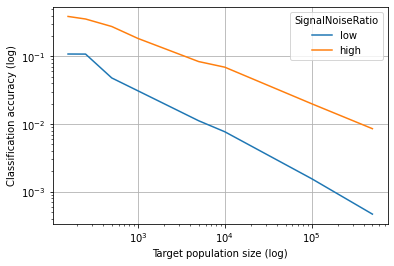

In [ ]:
sim_results_df = pd.DataFrame(sim_results, columns=['target_noise', 'popsize', 'accuracy'])
sim_results_df.to_csv('sim_results.csv')
sim_results_df['SignalNoiseRatio'] = ['high' if i < sim_results_df.target_noise.median() else "low" for i in sim_results_df.target_noise]

import seaborn as sns
sns.lineplot(x='popsize', y='accuracy', hue='SignalNoiseRatio', data=sim_results_df)
plt.xlabel('Target population size (log)')
plt.ylabel('Classification accuracy (log)')
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.savefig('accuracy_by_popsize.png')